# Inverting Gradients - How easy is it to break privacy in federated learning?

This notebook shows an example for a **small-batch image gradient inversion** as described in "Inverting Gradients - How easy is it to break privacy in federated learning?". The setting is a trained ResNet-18 and the federated learning algorithm is **fedAVG**.

Paper URL: https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html

This notebook can replicate the experiments in Fig.5 and Tab. 2 of this paper.

#### Abstract
The idea of federated learning is to collaboratively train a neural network on a server. Each user receives the current weights of the network and in turns sends parameter updates (gradients) based on local data. This protocol has been designed not only to train neural networks data-efficiently, but also to provide privacy benefits for users, as their input data remains on device and only parameter gradients are shared. But how secure is sharing parameter gradients? Previous attacks have provided a false sense of security, by succeeding only in contrived settings - even for a single image. However, by exploiting a magnitude-invariant loss along with optimization strategies based on adversarial attacks, we show that is is actually possible to faithfully reconstruct images at high resolution from the knowledge of their parameter gradients, and demonstrate that such a break of privacy is possible even for trained deep networks. We analyze the effects of architecture as well as parameters on the difficulty of reconstructing an input image and prove that any input to a fully connected layer can be reconstructed analytically independent of the remaining architecture. Finally we discuss settings encountered in practice and show that even averaging gradients over several iterations or several images does not protect the user's privacy in federated learning applications.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case=4_fedavg_small_scale", "case/data=CIFAR100"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case fedavg_small_scale with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.data.partition="random"
cfg.case.user.user_idx = 1
cfg.case.model='resnet18'

cfg.case.user.provide_labels = True

# These settings govern the total amount of user data and how it is used over multiple local update steps:
cfg.case.user.num_data_points = 4
cfg.case.user.num_local_updates = 4
cfg.case.user.num_data_per_local_update_step = 2


# Total variation regularization needs to be smaller on MNIST:
cfg.attack.regularization.total_variation.scale = 1e-3

max_length=100

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture resnet18 loaded with 11,220,132 parameters and 9,620 buffers.
Overall this is a data ratio of     913:1 for target shape [4, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR100
    user: 1
    
        
    Local FL Setup:
        Number of local update steps: 4
        Data per local update step: 2
        Local learning rate: 0.001

        Threat model:
        Share these hyperparams to server: True

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type Optimiz

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


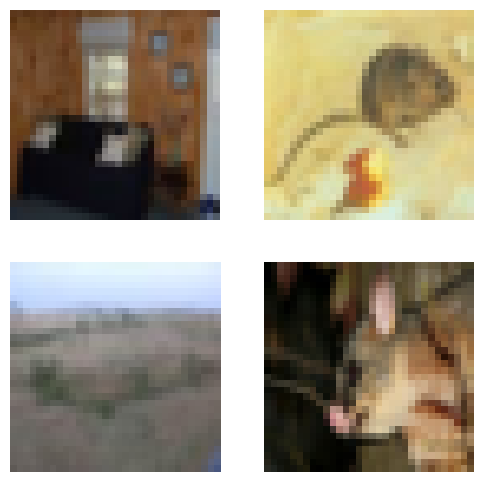

In [6]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 0.1370 |  Task loss: 3.8064 | T: 0.51s
| It: 101 | Rec. loss: 0.0339 |  Task loss: 3.6798 | T: 42.36s
| It: 201 | Rec. loss: 0.0244 |  Task loss: 3.6860 | T: 36.94s
| It: 301 | Rec. loss: 0.0206 |  Task loss: 3.6682 | T: 36.72s
| It: 401 | Rec. loss: 0.0206 |  Task loss: 3.6893 | T: 36.41s
| It: 501 | Rec. loss: 0.0216 |  Task loss: 3.6719 | T: 36.87s
| It: 601 | Rec. loss: 0.0197 |  Task loss: 3.6684 | T: 36.47s
| It: 701 | Rec. loss: 0.0194 |  Task loss: 3.6898 | T: 36.37s
| It: 801 | Rec. loss: 0.0185 |  Task loss: 3.6707 | T: 36.69s
| It: 901 | Rec. loss: 0.0191 |  Task loss: 3.6834 | T: 36.57s
| It: 1001 | Rec. loss: 0.0200 |  Task loss: 3.6688 | T: 36.65s
| It: 1101 | Rec. loss: 0.0190 |  Task loss: 3.6745 | T: 36.54s
| It: 1201 | Rec. loss: 0.0192 |  Task loss: 3.6653 | T: 36.70s
| It: 1301 | Rec. loss: 0.0183 |  Task loss: 3.6813 | T: 36.47s
| It: 1401 | Rec. loss: 0.0177 |  Task loss: 3.6864 | T: 36.68s
| It: 1501 | Rec. loss: 0.0178 |  Task loss: 3.6692 |

| It: 12801 | Rec. loss: 0.0126 |  Task loss: 3.7829 | T: 36.62s
| It: 12901 | Rec. loss: 0.0148 |  Task loss: 3.7723 | T: 36.59s
| It: 13001 | Rec. loss: 0.0145 |  Task loss: 3.7641 | T: 36.59s
| It: 13101 | Rec. loss: 0.0154 |  Task loss: 3.7611 | T: 36.54s
| It: 13201 | Rec. loss: 0.0149 |  Task loss: 3.7811 | T: 36.76s
| It: 13301 | Rec. loss: 0.0154 |  Task loss: 3.7709 | T: 36.62s
| It: 13401 | Rec. loss: 0.0152 |  Task loss: 3.7720 | T: 36.65s
| It: 13501 | Rec. loss: 0.0142 |  Task loss: 3.7775 | T: 36.54s
| It: 13601 | Rec. loss: 0.0142 |  Task loss: 3.7472 | T: 36.54s
| It: 13701 | Rec. loss: 0.0149 |  Task loss: 3.7615 | T: 36.61s
| It: 13801 | Rec. loss: 0.0142 |  Task loss: 3.7499 | T: 36.59s
| It: 13901 | Rec. loss: 0.0148 |  Task loss: 3.7677 | T: 36.51s
| It: 14001 | Rec. loss: 0.0146 |  Task loss: 3.7696 | T: 36.68s
| It: 14101 | Rec. loss: 0.0171 |  Task loss: 3.7900 | T: 36.37s
| It: 14201 | Rec. loss: 0.0180 |  Task loss: 3.7744 | T: 36.66s
| It: 14301 | Rec. loss: 

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [8]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, max_length=max_length, setup=setup)

Starting evaluations for attack effectiveness report...
Files already downloaded and verified
METRICS: | MSE: 0.0059 | PSNR: 22.36 | FMSE: 1.2377e-03 | LPIPS: 0.03|
 R-PSNR: 22.36 | IIP-pixel: 100.00% | SSIM: 0.7551 | max R-PSNR: 23.51 | max SSIM: 0.8135 | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

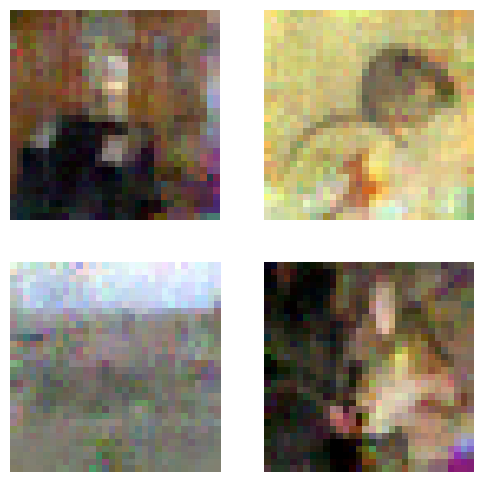

In [9]:
user.plot(reconstructed_user_data)

### Notes:
* If labels are unknown, then a robust label recovery algorithm has to be used that does not count label repetitions due to shifts after local updates.